ISS Computation took 33 [ms]
Extract PointCloud with 1719 points.
1719


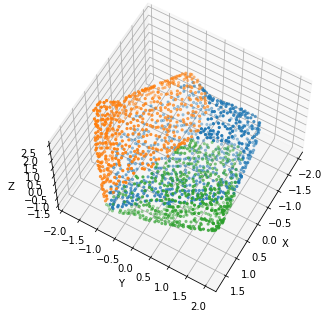

ISS Computation took 30 [ms]
Extract PointCloud with 1718 points.
1718


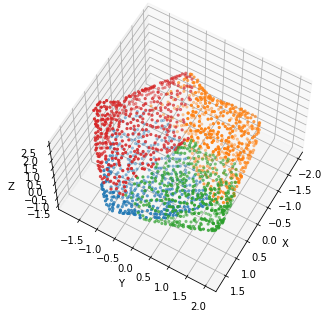

In [1]:
import numpy as np
from scipy.spatial import KDTree
import open3d as o3d
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


# 根据论文的手动复现iss算法，跑的非常慢而且不稳定
def get_iss_knn():
	knn = 20
	t1 = 0.05
	t2 = 0.05
	path = 'sa5_pointcloud.pcd'
	pcd = o3d.io.read_point_cloud(path)
	point = np.asarray(pcd.points)
	point_size = point.shape[0]
	ISS = np.array([0, 0, 0])
	mean_knn_source = np.zeros((point_size, knn, 3))
	mean_keypoint_source = np.zeros((point_size, 3))
	for i in range(point_size):
		tree = o3d.geometry.KDTreeFlann(pcd)
		[_, idx, dis] = tree.search_knn_vector_3d(point[i], knn + 1)
		mean_keypoint_source[i] = point[i]
		mean_knn_source[i] = point[idx[1:]]
		d_vector = mean_knn_source[i] - mean_keypoint_source[i]
		C_tem = np.sum(np.reshape((np.sum(d_vector[-1] ** 2) ** (1 / 2) - np.sum(d_vector ** 2, axis=1) ** (1 / 2)),
								  (knn, 1, 1)) * np.matmul(np.expand_dims(d_vector, axis=-1),
														   np.transpose(np.expand_dims(d_vector, axis=-1),
																		(0, 2, 1))), axis=0) / np.sum(
			(np.sum(d_vector[-1] ** 2) ** (1 / 2) - np.sum(d_vector[1:] ** 2, axis=1) ** (1 / 2)))
		eigvalue, eigvector = np.linalg.eig(C_tem)
		eigvalue = np.sort(eigvalue)
		if eigvalue[1] / eigvalue[2] <= t1 and eigvalue[0] / eigvalue[1] <= t2:
			ISS = np.vstack((ISS, point[i]))
	iss_point = ISS[1:]
	print(iss_point)

	return iss_point


#利用open3d带的库调用iss算法，算的速度非常快，但是最终结果和salient_radius以及not_max_radius有关，需要调整这两个参数
def keypoints_to_spheres(keypoints):
        spheres = o3d.geometry.TriangleMesh()
        for keypoint in keypoints.points:
         sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1)
         sphere.translate(keypoint)
         spheres += sphere
         spheres.paint_uniform_color([1.0, 0.75, 0.0])
        return spheres


def get_iss_o3d():
    pcd = o3d.io.read_point_cloud("sa5_pointcloud.pcd")
    tic = time.time()
    keypoints = o3d.geometry.keypoint.compute_iss_keypoints(pcd,
                                                            salient_radius=1,
                                                            non_max_radius=1,
                                                            gamma_21=0.8,
                                                            gamma_32=0.5)
    toc = 1000 * (time.time() - tic)
    print("ISS Computation took {:.0f} [ms]".format(toc))
    print("Extract", keypoints)
    print(len(keypoints.points))

    pcd.paint_uniform_color([0.0, 1.0, 0.0])
    o3d.visualization.draw_geometries([keypoints_to_spheres(keypoints),pcd], width=800, height=800)

    return keypoints.points



# 利用kmeans聚类去做
data = pd.DataFrame(get_iss_o3d())

data1 = data.iloc[:,0:3]


transfer = StandardScaler()
data_new = transfer.fit_transform(data1)
#data_old = transfer.fit_transform(data1)


estimator = KMeans(n_clusters = 3)

estimator.fit(data_new)
y_pred = estimator.predict(data_new)

fig = plt.figure()
ax = Axes3D(fig)
for i in range(3):
    ax.scatter3D(data_new[y_pred == i,0],data_new[y_pred == i,1],data_new[y_pred == i,2],marker = ".")
ax.view_init(elev = 60,azim = 30)
ax.set_zlabel('Z')
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()


#利用谱聚类去做
data = pd.DataFrame(get_iss_o3d())

data1 = data.iloc[:,0:3]


transfer = StandardScaler()
data_new = transfer.fit_transform(data1)


Spectral = SpectralClustering(n_clusters=2)
y_pred = Spectral.fit_predict(data_new)

fig = plt.figure()
ax = Axes3D(fig)
for i in range(2):
    ax.scatter3D(data_new[y_pred == i,0],data_new[y_pred == i,1],data_new[y_pred == i,2],marker = ".")
ax.view_init(elev = 60,azim = 30)
ax.set_zlabel('Z')
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()

